In [1]:
from pathlib import Path
import os
os.environ["OMP_NUM_THREADS"] = "2"  # To avoide warning in clustering, can try removing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp

import dill

%run "..//src//plots_for_spectral"

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")

In [2]:
with open(DATAFOLDER / "bazzino_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [4]:
framerate = 10
pre_window_size = 5 * framerate # frames before infusion
window_size = 200 # Total number of frames plotted around an infusion
frames_for_infusion = 10 * framerate # 10 seconds until end of infusion

populationdata = snips_photo
sortwindow = [pre_window_size, pre_window_size + frames_for_infusion] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.2 # Maximum colormap value. 

trial_types = ['trials']

C:\Users\jmc010\Github\bazzino\src\plots_for_spectral.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


(<Figure size 300x600 with 3 Axes>,
 array([<Axes: title={'center': 'trials'}, xlabel='Time from inf (s)', ylabel='Trials'>,
        <Axes: xlabel='Time from inf (s)', ylabel='Mean norm. fluor.'>],
       dtype=object))

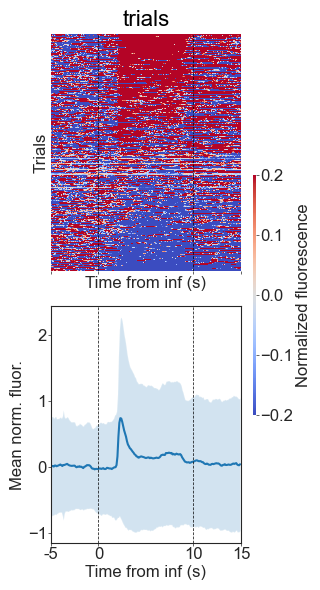

In [5]:
make_tsplot(populationdata,
            sortresponse,
            framerate,
            pre_window_size,
            window_size,
            frames_for_infusion,
            cmax,
            trial_types,
            )


Number of PCs = 200
Number of PCs to keep = 10


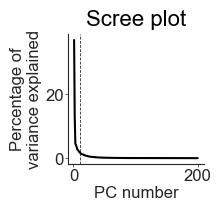

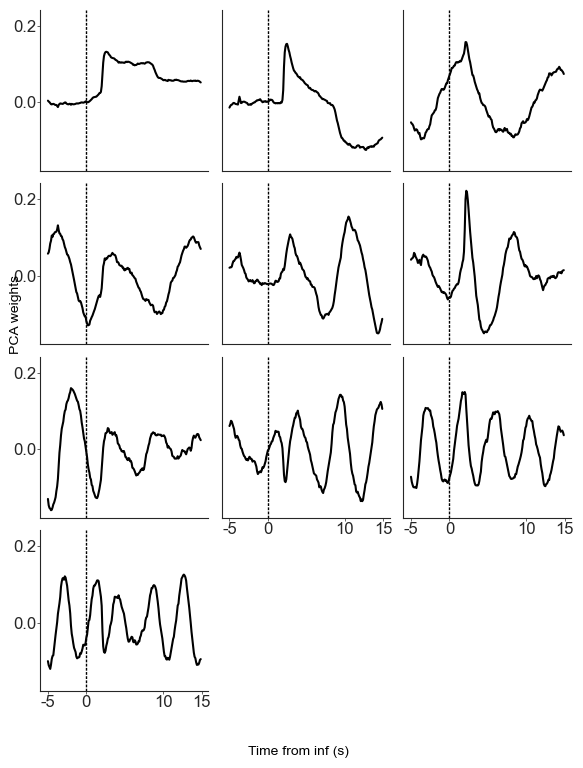

In [6]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(RESULTSFOLDER / 'pcaresults_photo.pickle', 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(RESULTSFOLDER / 'pcaresults_photo.pickle', 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
with open(RESULTSFOLDER / 'transformed_data_photo.pickle', 'wb') as f:
        pickle.dump(transformed_data, f)

pca_vectors = pca.components_
print('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print('Number of PCs to keep = %d'%(num_retained_pcs))

%run "..//src//plots_for_spectral"

# Plot scree plot
f, ax = plot_scree(x, pca, num_retained_pcs)
# Plot PCA vectors
f, axs = plot_pca_vectors(pca_vectors,
                          num_retained_pcs,
                          framerate,
                          pre_window_size,
                          window_size,
                          frames_for_infusion)

In [7]:
num_retained_pcs = 3

### Best silhouette score was with spectral clustering using a sigmoid and discretize
# when all trials are included
# 
max_n_clusters = 9 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).

silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    ))

possible_n_nearest_neighbors = np.array([400])

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
        model = SpectralClustering(n_clusters=n_clusters,
                                   affinity='sigmoid',
                                   assign_labels='discretize',
                                   random_state=0)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print('Done with numclusters = %d: score = %.3f'%(n_clusters, silhouette_scores[n_clustersidx,                                                                           
                                                                                                ]))

print('Done with model fitting')

Done with numclusters = 2: score = 0.397
Done with numclusters = 3: score = 0.370
Done with numclusters = 4: score = 0.328
Done with numclusters = 5: score = 0.149
Done with numclusters = 6: score = 0.035
Done with numclusters = 7: score = -0.010
Done with numclusters = 8: score = -0.058
Done with numclusters = 9: score = -0.183
Done with model fitting


In [8]:
temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(RESULTSFOLDER / 'silhouette_scores_photo.pickle', 'wb') as f:
    pickle.dump(temp, f)

In [9]:
with open(RESULTSFOLDER / 'silhouette_scores_photo.pickle', 'rb') as f:
    silhouette_scores = pickle.load(f)
    
# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]

print (n_clusters)

with open(RESULTSFOLDER / 'transformed_data_photo.pickle', 'rb') as f:
    transformed_data = pickle.load(f)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=2,
                           affinity='sigmoid',
                           assign_labels='discretize',)

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(populationdata,
                     rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(populationdata,
                             model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

np.save(RESULTSFOLDER / 'clusterlabels_photo.npy', newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      "green",
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

2
Number of clusters = 2, average silhouette = 0.402


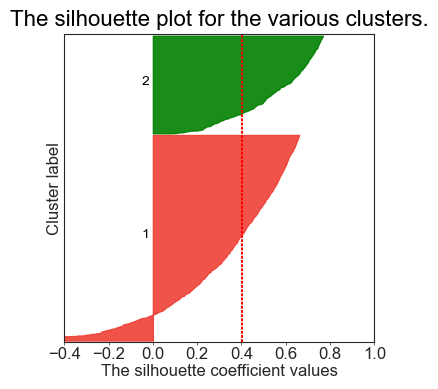

In [ ]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs],
                     model.labels_,
                     colors_for_cluster=colors_for_cluster,)

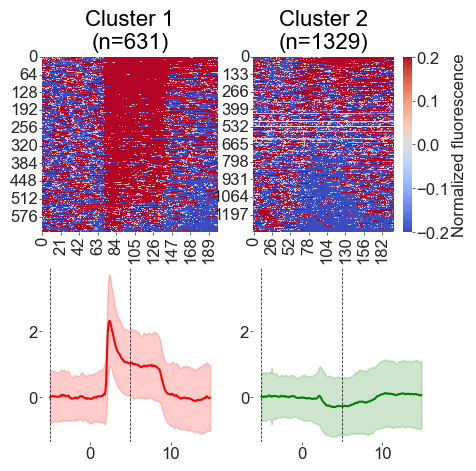

In [11]:
show_clusters(populationdata,
              newlabels,
                uniquelabels,
                pre_window_size,
                frames_for_infusion,
                window_size,
                framerate,
                cmax)


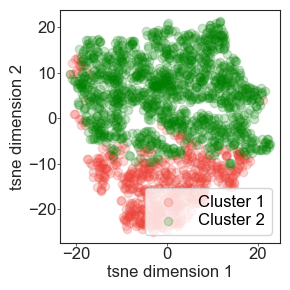

In [106]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=100)
        Y = tsne.fit_transform(X)
        #ax = axs[int(tempsum/numcols),
        #         int(tempsum - tempsum/numcols*numcols)]
        
        try:
            ax = axs.flat[tempsum]
        except:
            ax = axs
        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=0.2)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=0.2)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [12]:
# saves photo labels
x_array = x_array.assign(cluster_photo=newlabels)

## Clustering of behavioural responses

In [13]:
def smooth_array(arr, window_size=5):
    """
    Smooth a 2D array along one dimension using a moving average.
    
    :param arr: 2D NumPy array
    :param window_size: Size of the smoothing window
    :return: Smoothed 2D array
    """
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)
    return smoothed

# Example usage
snips_vel = smooth_array(snips_vel, window_size=5)

In [14]:
populationdata = snips_vel
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]


C:\Users\jmc010\Github\bazzino\src\plots_for_spectral.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


(<Figure size 300x600 with 3 Axes>,
 array([<Axes: title={'center': 'trials'}, xlabel='Time from inf (s)', ylabel='Trials'>,
        <Axes: xlabel='Time from inf (s)', ylabel='Mean norm. fluor.'>],
       dtype=object))

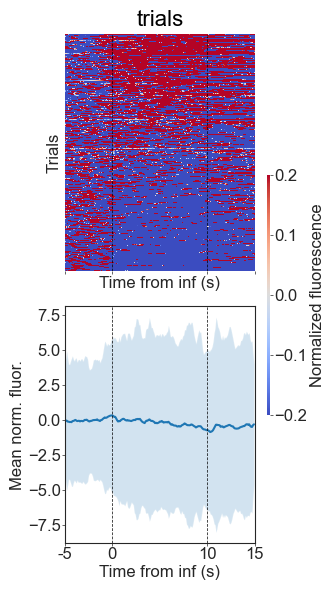

In [15]:
make_tsplot(populationdata,
            sortresponse,
            framerate,
            pre_window_size,
            window_size,
            frames_for_infusion,
            cmax,
            trial_types,
            )

Number of PCs = 200
Number of PCs to keep = 7


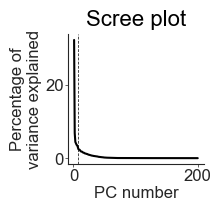

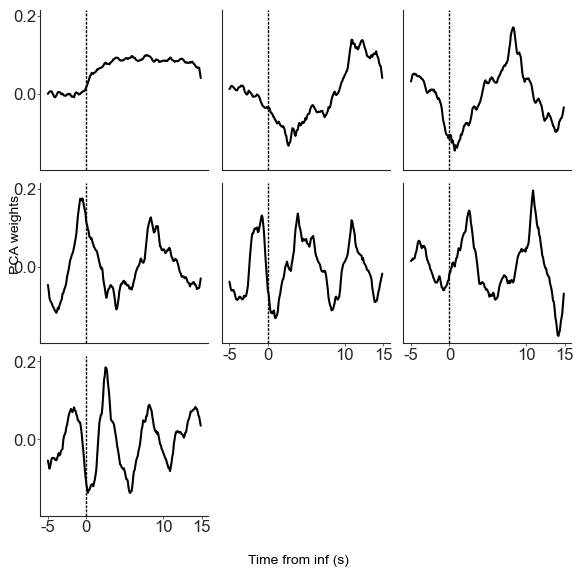

In [24]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(RESULTSFOLDER / 'pcaresults_vel.pickle', 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(RESULTSFOLDER / 'pcaresults_vel.pickle', 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
with open(RESULTSFOLDER / 'transformed_data_vel.pickle', 'wb') as f:
        pickle.dump(transformed_data, f)

pca_vectors = pca.components_
print('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print('Number of PCs to keep = %d'%(num_retained_pcs))

%run "..//src//plots_for_spectral"

# Plot scree plot
f, ax = plot_scree(x, pca, num_retained_pcs)
# Plot PCA vectors
f, axs = plot_pca_vectors(pca_vectors,
                          num_retained_pcs,
                          framerate,
                          pre_window_size,
                          window_size,
                          frames_for_infusion)

In [25]:
num_retained_pcs = 3

### Best silhouette score was with spectral clustering using a sigmoid and discretize
# when all trials are included
# 
max_n_clusters = 9 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).

silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    ))

possible_n_nearest_neighbors = np.array([50, 100, 200, 400])

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
        model = SpectralClustering(n_clusters=n_clusters,
                                   affinity='sigmoid',
                                   assign_labels='discretize',
                                   random_state=0)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print('Done with numclusters = %d: score = %.3f'%(n_clusters, silhouette_scores[n_clustersidx,                                                                           
                                                                                                ]))

print('Done with model fitting')



Done with numclusters = 2: score = 0.213
Done with numclusters = 3: score = 0.117
Done with numclusters = 4: score = 0.049
Done with numclusters = 5: score = 0.090
Done with numclusters = 6: score = -0.032
Done with numclusters = 7: score = 0.073
Done with numclusters = 8: score = 0.017
Done with numclusters = 9: score = 0.072
Done with model fitting


In [26]:
temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(RESULTSFOLDER / 'silhouette_scores_vel.pickle', 'wb') as f:
    pickle.dump(temp, f)

In [27]:
temp

{'possible_n_clusters': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'silhouette_scores': array([ 0.21295231,  0.11685767,  0.04883168,  0.08992838, -0.0323878 ,
         0.07309966,  0.01718162,  0.07235953]),
 'shape': 'cluster_nn'}

In [28]:
with open(RESULTSFOLDER / 'silhouette_scores_vel.pickle', 'rb') as f:
    silhouette_scores = pickle.load(f)
    
# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]

print (n_clusters)

# with open(RESULTSFOLDER / 'transformed_data_vel.pickle', 'rb') as f:
#     transformed_data = pickle.load(f)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=2,
                           affinity='sigmoid',
                           assign_labels='discretize',)

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(populationdata,
                     rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels

newlabels = reorder_clusters(populationdata,
                             model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

np.save(RESULTSFOLDER / 'clusterlabels_vel.npy', newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      "green",
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

2
Number of clusters = 2, average silhouette = 0.213


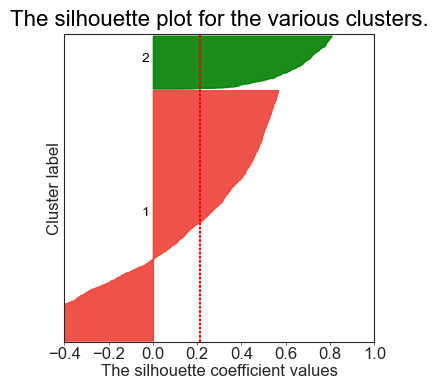

In [29]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs],
                     model.labels_,
                     colors_for_cluster=colors_for_cluster,)

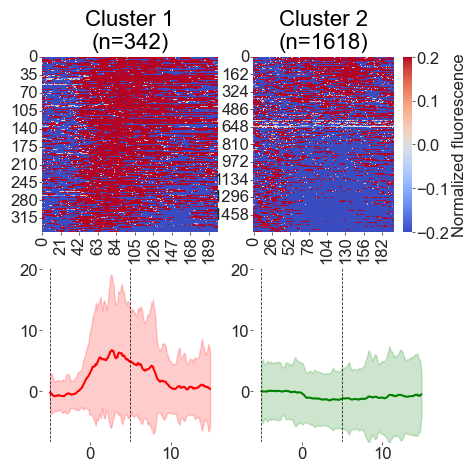

In [30]:
show_clusters(populationdata,
              newlabels,
                uniquelabels,
                pre_window_size,
                frames_for_infusion,
                window_size,
                framerate,
                cmax)


In [31]:
x_array = x_array.assign(cluster_vel=newlabels)

In [32]:
x_array.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'cluster_photo',
       'cluster_vel'],
      dtype='object')

In [33]:
with open(DATAFOLDER / "bazzino_data_with_clusters.pickle", "wb") as f:
    dill.dump({
        "x_array": x_array,
        "snips_photo": snips_photo,
        "snips_vel": snips_vel
    }, f)

